In [1]:
import numpy as np 
import astropy.units as u
import matplotlib.pyplot as plt 
import seaborn as sns

from astropy import io
from galpy import potential

sns.set()

### Problem 1: Dark matter and scaling relations in disk galaxies.

In one of the recent Q&A sessions, we played with rotation curves from the SPARC
compilation (Lelli et al. 2016) and decomposed them into disk and halo contributions. Let’s
see what else we can learn about dark matter and galaxy structure from these data!

Important note: You can use the functions from the class notebook to load the and
process the data, but be aware that the table entries as read by the code do not appear to
have proper astropy units set. This means that when you naively pass them to, e.g., galpy
functions, galpy will interpret the input as having no units. You can get around this issue by
explicitly casting the table to the units that you want, for example, data[’R’].to(u.kpc).
If you use galpy for this problem (which is probably useful. . . ), it may also help to add a
configuration file1 with astropy-units = True (this is not the default) to the directory in
which you are working. That way, galpy functions will always return astropy Quantities
with units attached. https://docs.galpy.org/en/latest/installation.html#configuration-file

(a) When we did the exercise in class, we used disk rotation curves that were unconstrained by other data. But we in fact have surface-brightness measurements for all of the
galaxies in the sample (included in the table as SBdisk), which we can use to determine
an appropriate disk rotation curve and its contribution to the total rotation curve. For the
three galaxies that we studied in class, re-fit the rotation curve as a razor-thin disk plus
NFW halo, but first finding good disk parameters by fitting the surface brightness profile
(assume M/L = 1 as is appropriate in the mid-IR used in the SPARC compilation). You
can just fit by hand and determine parameters that roughly fit by eye.

In [2]:
raw = io.ascii.read('MassModels_Lelli2016c.mrt')
ugc05 = raw[raw['ID'] == 'UGC05918']
ugc08 = raw[raw['ID'] == 'UGC08490']
ngc65 = raw[raw['ID'] == 'NGC6503']

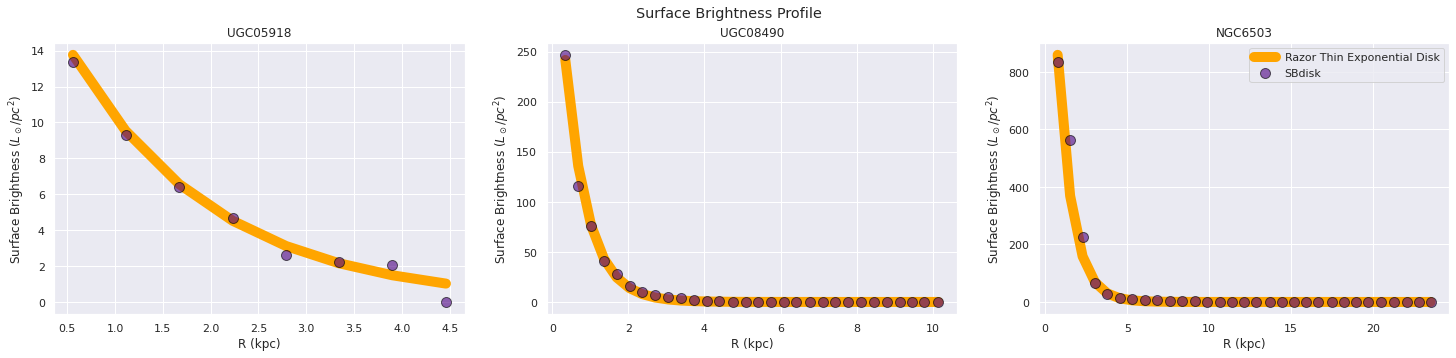

In [62]:
disk_surfdens = [20.,430,2000]*u.Msun/u.pc**2
disk_scalelen = [1.5,0.59,.9]*u.kpc
gal = [ugc05,ugc08,ngc65]
galname = ['UGC05918','UGC08490','NGC6503']


f, axes = plt.subplots(1,3,figsize=(25,5))

for i,ax in enumerate(axes):

    R = np.array(gal[i]['R']) * u.kpc
    
    disk = potential.RazorThinExponentialDiskPotential(amp=disk_surfdens[i],hr=disk_scalelen[i])

    # Set vertical height to be 0 so surface density will be in plane of the disk. 
    surface_density = disk.surfdens(R,0) 

    ax.plot(R,surface_density,label="Razor Thin Exponential Disk",c="orange",lw=10)

    ax.scatter(R,gal[i]['SBdisk'],label="SBdisk",c="indigo",edgecolor="black",alpha=.6,s=100,zorder=10)

    ax.set_title(galname[i])
    ax.set_xlabel('R (kpc)')
    ax.set_ylabel(r'Surface Brightness ($L_\odot / pc^2 $)')
axes[2].legend()
plt.suptitle("Surface Brightness Profile");

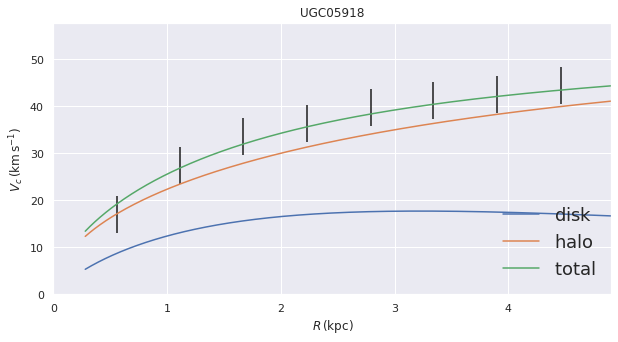

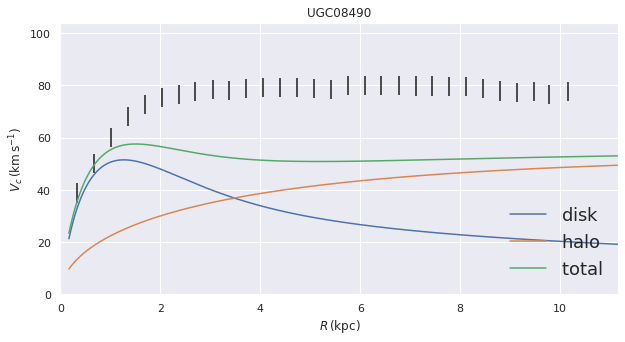

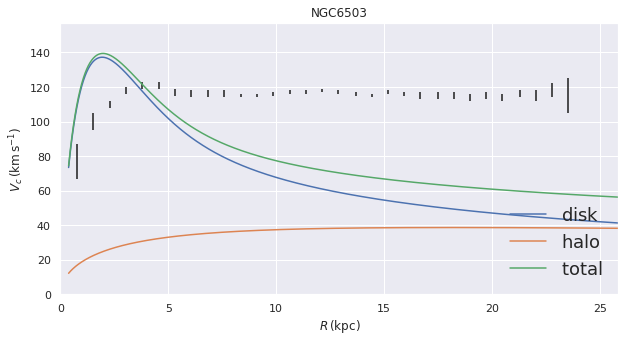

In [119]:
halo_virial_mass = [5e10,5e10,2e10] * u.Msun
halo_conc = [10,10,10]

#plt.suptitle("Rotation Curve as a Razor-Thin Disk plus NFW Halo");

for i in range(3):
    plt.figure(figsize=(10,5))


    disk = potential.RazorThinExponentialDiskPotential(amp=disk_surfdens[i],hr=disk_scalelen[i])
    halo= potential.NFWPotential(mvir=halo_virial_mass[i].to_value(1e12*u.Msun),conc=halo_conc[i],ro=8.,vo=220.)
    disk_halo = disk + halo

    plt.xlim(0.,1.1*np.max(gal[i]['R']))
    plt.ylim(0.,1.3*np.max(gal[i]['Vobs']))

    R = np.array(gal[i]['R']) * u.kpc
    R_range = [.5 * R.min(),1.1*R.max()]
    V = np.array(gal[i]['Vobs']) * u.km / u.s
    V_er = np.array(gal[i]['e_Vobs']) * u.km / u.s
    plt.errorbar(R.value,V.value,yerr=V_er.value,ls='none',color='k')
    disk.plotRotcurve(Rrange=R_range,overplot=True,label=r'$\mathrm{disk}$')
    halo.plotRotcurve(Rrange=R_range,overplot=True,label=r'$\mathrm{halo}$')
    potential.plotRotcurve(disk+halo,Rrange=R_range,overplot=True,label=r'$\mathrm{total}$')
    plt.title(galname[i])
    plt.ylabel(r'$V_c\,(\mathrm{km\,s}^{-1})$')
    plt.xlabel(r'$R\,(\mathrm{kpc})$')
    plt.legend(loc='lower right',frameon=False,fontsize=18.)
    
    

(b) What do you learn about the dark matter contribution in these
galaxies?

(c) The Tully-Fisher relation is a famous scaling relation for disk
galaxies that relates a galaxies asymptotic velocity $V_\infty$ to its
luminosity. It can be used, for example, to obtain distances to
galaxies, because the rotation velocity can be measured relatively
easily and the luminosity obtained from the relation can then be
combined with the observed magnitude to obtain the distance. It's also
a useful constraint on galaxy formation models. Let's use the
bulgeless SPARC galaxies to measure the Tully-Fisher relation
ourselves! To obtain a quantitative determination of $V_\infty$, we can
fit the rotation curves with a gravitational potential of the form

\begin{equation}
  \phi(r) = {v_0^2\over 2}\,\ln\left(r^2 + r_0^2\right)\,,
\end{equation}

with two free parameters, $v_0$ and $r_0$. Determine the circular
velocity as a function of radius $v_c(r)$ for this potential. What is
$V_\infty$ in terms of $v_0$ and $r_0$?

(d) Now fit this model to all bulgeless SPARC galaxies. Fit the model rotation velocity by minimizing $\chi^2$ defined as

\begin{equation}
  \chi^2 = \sum_i {\left[v_c(\texttt{R}_i) - \texttt{Vobs}_i\right]^2 \over \texttt{e\_Vobs}_i^2}\,,
\end{equation}

where $i$ indexes the $N$ data points for each galaxy
$\{\texttt{R}_i,\texttt{Vobs}_i,\texttt{e\_Vobs}_i\}$. You can use
\texttt{scipy} optimization functions for this. Compare the model fit
to the observed rotation curve for the three galaxies from part (a)
and do the fit for all 143 bulgeless galaxies.

(e) Now derive the Tully-Fisher relation by computing the total
luminosity of each galaxy and plotting $V_\infty$ versus the total
luminosity. Discuss what you see. The Tully-Fisher relation is
generally well fit as $L \propto V_\infty^\alpha$; if you fit this form
to your obtained relation, what value for $\alpha$ do you get (you can
fit without taking errors into account). What $\alpha$ do you get if
you only include $L > 10^{10}\,L_\odot$ galaxies? Which of these two
determinations do you think is more accurate and why?

### Problem 2: The zero-velocity curve.

When we looked at orbits in disk galaxies, we discussed the
zero-velocity curve: the curve in the meridional plane $(R,z)$ where
$v_R = v_z = 0$. Let's explore this important curve further!



(a) For the example orbit in Chapter 10.1, we showed
the zero-velocity curve as a constant energy contour, but we could
also explicitly compute $z$ as a function of $(R,E,L_z)$ on the
zero-velocity curve by demanding that $v_R = v_z = 0$. Do this for the
first example orbit in Chapter 10.1 and compare to the zero-velocity
curve that you get from the contouring method. (note that you may not
be able to solve for $z$ analytically and might have to resort to
numerical methods\ldots)

(b) In the notes, we discussed how orbits touch the
zero-velocity curve at four points, but there are orbits at a given
$(E,L_z)$ that only touch the zero-velocity curve at \emph{two}
points. These orbits are called the thin tubes, because in 3D they
look like a tube (that's thin!). Devise an algorithm to find this
orbit for a given $(E,L_z)$ and apply it to the $(E,L_z)$ of the
example orbit in (a) [there are various, qualitatively different ways
  to do this; explain why your algorithm works in general]. Show the
orbit in $(R,z)$ and $(x,y,z)$? Discuss what you think is interesting
about this orbit.